#FASTAI for Image Classification

In [2]:
# transfer learning for image classifier on pets dataset.
# On Google Colab, CPU training takes 30 minutes for first epoch, GPU takes 1 minutes
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images' # download the data and untar it

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(# this means the image label is "solved" from the file name
    path, # the path to the data
    get_image_files(path), # get_image_files just gives a list of image filepaths
    label_func=is_cat, # this function determines the label of a file
    item_tfms=Resize(224), # item transforms are applied to each image, larger images sizes can improve performance
    valid_pct=0.2, seed=42)

# lets fine tune, renset34 has already been trained on 1.3 imagenet photos
learn = vision_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 58.0MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.174297,0.021110,0.008119,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.049316,0.013155,0.002706,00:47


In [3]:
# quick look at data. Notice label is given by prefix of file name and only cats are capitalized, hence the label function is_cat above.
print('Data downloaded from:', URLs.PETS)
print('Example files:')
for p in path.ls()[:5]:
  print(p)

Data downloaded from: https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz
Example files:
/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_74.jpg
/root/.fastai/data/oxford-iiit-pet/images/newfoundland_171.jpg
/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_6.jpg
/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_188.jpg
/root/.fastai/data/oxford-iiit-pet/images/keeshond_175.jpg


Is this a cat?: True.
Probability it's a cat: 1.000000


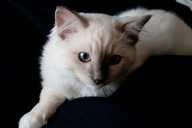

In [4]:
# view the fist image and get a prediction:
img = PILImage.create(path.ls()[0])
is_cat, _ ,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")
img.to_thumb(192)

#Image Segmentation

In [6]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/labels')]

In [7]:
# view the codes
np.loadtxt(path/'codes.txt', dtype=str)

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [10]:
# lets's look at the files:
print('Example images')
for p in (path/'images').ls()[:5]:
  print(p)
print('Example labels')
for p in (path/'labels').ls()[:5]:
  print(p)


Example images
/root/.fastai/data/camvid_tiny/images/Seq05VD_f01320.png
/root/.fastai/data/camvid_tiny/images/0001TP_008400.png
/root/.fastai/data/camvid_tiny/images/0016E5_00840.png
/root/.fastai/data/camvid_tiny/images/0006R0_f03330.png
/root/.fastai/data/camvid_tiny/images/0006R0_f02550.png
Example labels
/root/.fastai/data/camvid_tiny/labels/0001TP_008670_P.png
/root/.fastai/data/camvid_tiny/labels/0016E5_01260_P.png
/root/.fastai/data/camvid_tiny/labels/Seq05VD_f03210_P.png
/root/.fastai/data/camvid_tiny/labels/Seq05VD_f02880_P.png
/root/.fastai/data/camvid_tiny/labels/0016E5_08141_P.png


In [11]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,3.260221,2.823333,00:01


epoch,train_loss,valid_loss,time
0,2.185553,1.910745,00:01
1,1.783157,1.707454,00:01
2,1.622196,1.566837,00:02
3,1.431990,1.153220,00:01
4,1.257864,1.008216,00:01
5,1.111013,0.944792,00:01
6,0.996543,0.943548,00:01
7,0.908996,0.927645,00:01


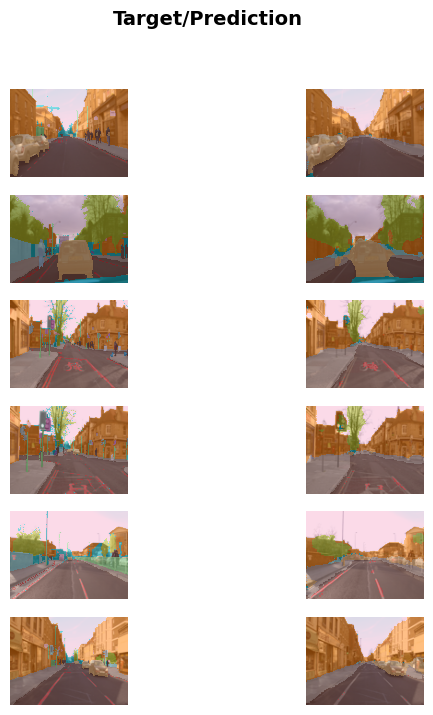

In [12]:
learn.show_results(max_n=6, figsize=(7,8))

#Downloading Images and training classifier.

In [17]:
!pip install duckduckgo_search

In [44]:
from duckduckgo_search import ddg_images
def search_images(text, max_results=30):
  responses = ddg_images(text, max_results)
  urls = [r['image'] for r in responses]
  return urls
urls = search_images('bird_photos', max_results=30)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")


<Axes: title={'center': 'bluebird.jpg'}>

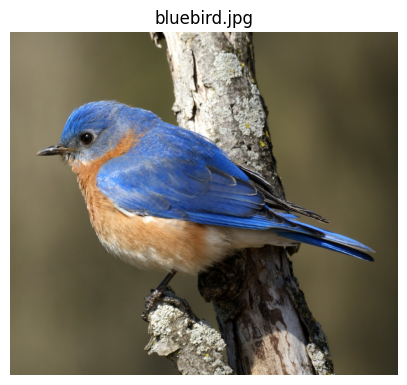

In [30]:
# example downloading one image
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)
image = PILImage.create(dest)
image.show(title = Path(urls[0]).name)

In [54]:
searches = ['forest','bird']
path = Path('bird_or_not')
from time import sleep
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    for setting in ['photo', 'sun photo', 'shade photo']:
      search_string = f'{o} {setting}'
      print('Downloading', search_string, 'images.')
      download_images(dest, urls=search_images(search_string))
# and resize
resize_images(path, max_size=400, dest=path)

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")


In [55]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

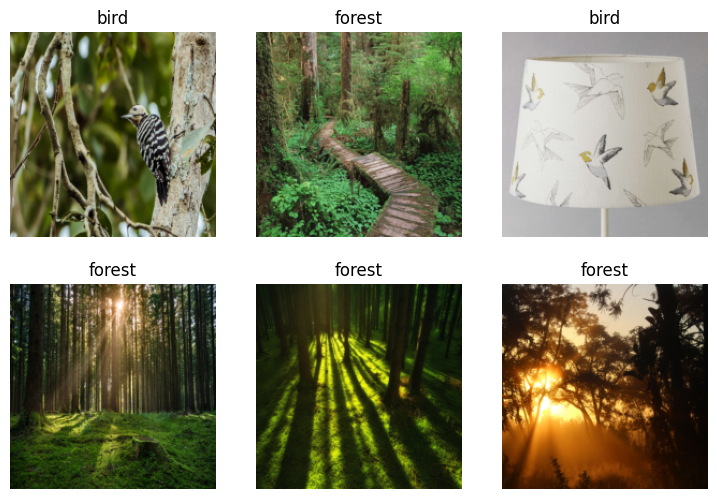

In [56]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [58]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.636402,0.016292,0.009901,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.039487,0.057725,0.019802,00:40
